# [Multi-class classification with focal loss for imbalanced datasets](https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/)
## Baseline model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
np.random.seed(42)

In [2]:
# create data frame containing your data, each column can be accessed # by df['column   name']
dataset = pd.read_csv('../input/PS_20174392719_1491204439457_log.csv')
del dataset['nameDest']
del dataset['nameOrig']
del dataset['type']

dataset.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [3]:
dataset['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

### Prepare the data
Let's make a train-test split and normalize the features. We are using the first six columns of the data frame show above as features, and the "isFraud" column as labels.

In [4]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma

In [5]:
# splitting the training/test data
from sklearn.model_selection  import train_test_split
X, y = dataset.iloc[:,:-2], dataset.iloc[:, -2]
y = keras.utils.to_categorical(y, num_classes=2)
X = feature_normalize(X.as_matrix())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Build the model
We make a simple dense neural network with four fully connected layers. The last layer uses a softmax activation to produce output scores for normal and fraud classes in the range [0, 1].

In [6]:
from tensorflow.keras.models import Sequential
import tensorflow as tf

model = Sequential()

from tensorflow.keras.layers import Dense

input_dim = X_train.shape[1]
nb_classes = y_train.shape[1]

model.add(Dense(10, input_dim=input_dim, activation='relu', name='input'))
model.add(Dense(20, activation='relu', name='fc1'))
model.add(Dense(10, activation='relu', name='fc2'))
model.add(Dense(nb_classes, activation='softmax', name='output'))

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 10)                70        
_________________________________________________________________
fc1 (Dense)                  (None, 20)                220       
_________________________________________________________________
fc2 (Dense)                  (None, 10)                210       
_________________________________________________________________
output (Dense)               (None, 2)                 22        
Total params: 522
Trainable params: 522
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [9]:
# from sklearn.utils import class_weight
# class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight = {0 : 1., 1: 20.}
model.fit(X_train, y_train, epochs=3, batch_size=1000, class_weight=class_weight)

Epoch 1/3
5090096/5090096 [==============================] - 7s 1us/step - loss: 0.0532 - acc: 0.9969
Epoch 2/3
5090096/5090096 [==============================] - 7s 1us/step - loss: 0.0322 - acc: 0.9980
Epoch 3/3
5090096/5090096 [==============================] - 7s 1us/step - loss: 0.0285 - acc: 0.9980


After the model is trained, we run evaluation on the test set.

In [10]:
eval_loss, eval_accuracy = model.evaluate(X_test, y_test, batch_size=1000)
print("Evaluation loss:", eval_loss)
print("Evaluation accuracy:", eval_accuracy)

1272524/1272524 [==============================] - 1s 1us/step
Evaluation loss: 0.008929372450242485
Evaluation accuracy: 0.9985485622594318


 Notice that the eval loss and accuracy are comparable with or better than the reported loss and accuracy during training. This means that our model did not overfit during training.

### Predict normal vs. fraud on test set data
Now, let's analyze our model's performance on the test set data. We'll look at confusion matrix plots and calculate the F1 score.

In [11]:
# use trained model to predict normal vs. fraud on the test set
predictions = model.predict(X_test, batch_size=1000)
np.set_printoptions(precision=3, suppress=True)
print(predictions)

[[0.9   0.1  ]
 [0.997 0.003]
 [0.992 0.008]
 ...
 [1.    0.   ]
 [0.999 0.001]
 [0.91  0.09 ]]


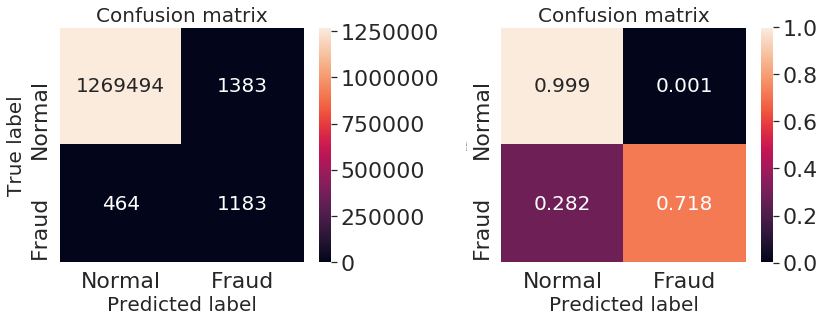

In [12]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

# convert predictions to labels
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)
# make confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels)
# normalize confusion matrix 
n_truth = np.sum(confusion_matrix, axis=1, keepdims=True)
confusion_matrix_normalized = confusion_matrix / n_truth

# plot raw confusion matrix
LABELS = ['Normal','Fraud'] 
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)

# plot normalized confusion matrix
plt.subplot(122)
sns.heatmap(confusion_matrix_normalized, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".3f", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=2)
plt.xlabel('Predicted label', fontsize=20)
plt.tight_layout()
plt.show()

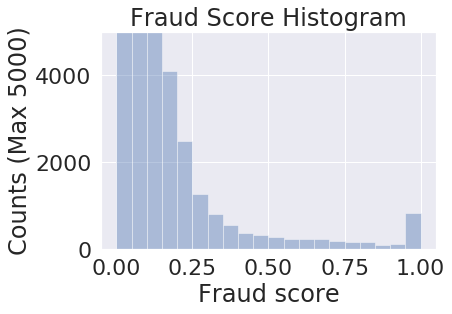

In [13]:
plt.figure()
sns.distplot(predictions[:, 1], bins=20, kde=False);
plt.ylim([0, 5000])
plt.xlabel("Fraud score")
plt.ylabel("Counts (Max 5000)")
plt.title("Fraud Score Histogram")
plt.show()

In [14]:
f1_score = metrics.f1_score(y_test_labels, y_pred_labels)
print("F1 score:", f1_score)

values = confusion_matrix.view()
error_count = values.sum() - np.trace(values)
print("Total misclassified samples:", error_count)

F1 score: 0.561595062900546
Total misclassified samples: 1847
